In [4]:
from ThesisPackage.Environments.soccer.soccer_env_multi import SoccerGame
from ThesisPackage.RL.Decentralized_PPO_soccer.multi_ppo import PPO_Multi_Agent
from ThesisPackage.RL.Decentralized_PPO.util import flatten_list, reverse_flatten_list_with_agent_list
from ThesisPackage.Wrappers.frame_stack import ParallelFrameStack
from ThesisPackage.Wrappers.vecWrapper import PettingZooVectorizationParallelWrapper
import torch
import time

In [5]:
def make_env(noise_team=1):
    env = SoccerGame(20, 12, sequence_length=2, vocab_size=3, noise_team=noise_team)
    env = ParallelFrameStack(env, 4)
    return env

In [6]:
env = make_env()
agent = PPO_Multi_Agent(env, device="cpu")

agent.agent.load_state_dict(torch.load("/Users/cowolff/Documents/GitHub/ma.pong_rl/models/soccer_2vs2.pt"))

<All keys matched successfully>

In [7]:
def test(env, agent):
    obs, infos = env.reset()
    wins = []
    for j in range(1000):
        while True:
            obs = flatten_list([obs])
            obs = torch.tensor(obs, dtype=torch.float32)
            actions, _, _, _ = agent.agent.get_action_and_value(obs)
            actions = actions.detach().numpy()
            actions = reverse_flatten_list_with_agent_list(actions, env.agents)
            obs, reward, truncations, terminations, infos = env.step(actions[0])
            if any([truncations[agent] or terminations[agent] for agent in env.agents]):
                teams = [infos[agent]["team"] for agent in env.agents if "team" in infos[agent]]
                if len(teams) > 0:
                    wins.append(teams[0])
                else:
                    wins.append(0)
                obs, infos = env.reset()
                break
    results = {"Team 1 wins": wins.count(1), "Team 2 wins": wins.count(-1)}
    return results

In [12]:
env = make_env(noise_team=1)
results = {}
results["1"] = test(env, agent)

/Users/cowolff/miniconda3/envs/thesis/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [13]:
env = make_env(noise_team=-1)
results["2"] = test(env, agent)

In [14]:
env = make_env(noise_team=0)
results["0"] = test(env, agent)

In [15]:
results

{'1': {'Team 1 wins': 678, 'Team 2 wins': 316},
 '2': {'Team 1 wins': 768, 'Team 2 wins': 231},
 '0': {'Team 1 wins': 753, 'Team 2 wins': 241}}

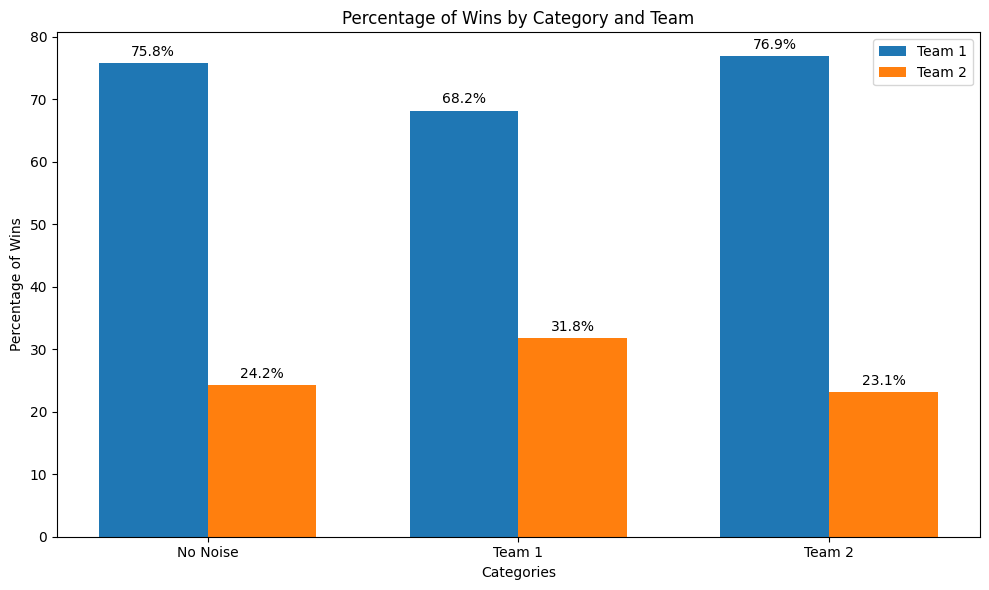

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate percentages
categories = ['0', '1', '2']  # Arrange categories in the desired order
total_wins = {cat: results[cat]['Team 1 wins'] + results[cat]['Team 2 wins'] for cat in categories}

team1_percentages = [results[cat]['Team 1 wins'] / total_wins[cat] * 100 for cat in categories]
team2_percentages = [results[cat]['Team 2 wins'] / total_wins[cat] * 100 for cat in categories]

categories_labels = {0: 'No Noise', 1: 'Team 1', 2: 'Team 2'}
categories_labels = [categories_labels[int(cat)] for cat in categories]

# Plotting the bar charts side by side
bar_width = 0.35
index = np.arange(len(categories))

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(index - bar_width/2, team1_percentages, bar_width, label='Team 1')
bar2 = ax.bar(index + bar_width/2, team2_percentages, bar_width, label='Team 2')

ax.set_xlabel('Categories')
ax.set_ylabel('Percentage of Wins')
ax.set_title('Percentage of Wins by Category and Team')
ax.set_xticks(index)
ax.set_xticklabels(categories_labels)
ax.legend()

# Add percentage labels on top of each bar
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)

plt.tight_layout()
plt.show()